从LOF过来的文件。LOF+Grubbs+BN
---

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import scale
from mpl_toolkits.mplot3d import Axes3D
# import sklearn as sl
# from sklearn.neighbors import LocalOutlierFactor

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# plt.style.use('default')
font1 ={'family': 'times', 'weight':'light', 'size': 12}  
# font2 ={'family': 'Arial', 'weight':'normal', 'size': 12}  
def Plot_XZ(elec_year, elec_faults):
# 画出原始图
    Company_names = ['Xizang', 'Xinjiang', 'Heilongjiang']
    j= 0
    plt.figure(figsize=(4, 3), facecolor='w')
    ax = plt.subplot(1, 1, 1)
    for jx in range(11):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=3, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')

    plt.show()
    return 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


D:\Softwares\Python\Python_Anaconda\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


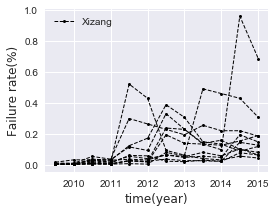

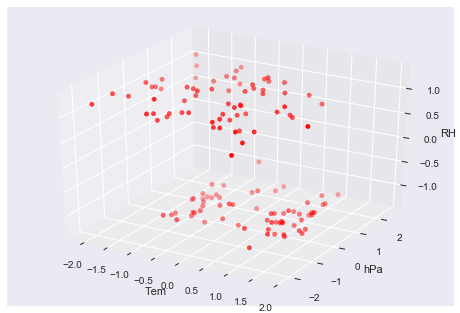

In [3]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储

elec_data = pd.read_csv('XZnozero_12_longB.csv')
elec_dataA = pd.read_csv('XZnozero_12.csv')
# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中




# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 2, size=[len(elec_data.Year.values), 4])
SNR_Tem = np.random.normal(0, 0.5, size=[len(elec_data.Year.values), 1])
# #特征因素分析

elec_tem = elec_data.Tem.values + SNR_Tem[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)

# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)

elec_data.Fault.values[118] =210
elec_data.Fault.values[119] =150

elec_dataA.Fault.values[202] =210
elec_dataA.Fault.values[203] =150
elec_dataA.Fault.values[218] =165
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)

print(elec_faults)
elec_faultsA = 100 * (elec_dataA.Fault.values / elec_dataA.Nums.values)


# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(11)])
elec_year2 = np.array([elec_year[i*12:(i+1)*12] for i in np.arange(11)])
elec_faultsAC = np.array([elec_faultsA[i*12:(i+1)*12] for i in np.arange(25)])
elec_faults_A = elec_faultsAC[:7] #分别取ABC省的原始数据，用于计算LOF中的Grubbs
elec_faults_C = elec_faultsAC[18:]
# print(elec_faults_A)
# print(elec_faults_C)
# 画图
Plot_XZ(elec_year2, elec_faults2)

# plt.figure(figsize=(4, 3), facecolor='w')
ax = plt.subplot(111, projection='3d')
ax.scatter(elec_tem1, elec_hPa1, elec_RH1, c='r')
ax.set_zlabel('RH')  # 坐标轴
ax.set_ylabel('hPa')
ax.set_xlabel('Tem')
plt.show()

In [4]:
from lof import *
# Instane2_A, Instane2_B, Instane2_C：为故障+时间
# Instane5_A, Instane5_B, Instane5_C：为故障+时间+温度+压强+湿度
# 矩阵乘以权重需要将list转换为Numpy: np.array(Instane),才能调用切片
# 权重矩阵Weight为：
Weight = np.array([1.0, 0.7311650684715499, 0.4273930180878881 ,0.35659903015510097 ,0.6406373000946504])
Weight_sqrt = np.sqrt(Weight) #取平方根作为LOF权重
# 注意，一下数据全部已经和权重相乘了
Instane2_A =[
[ -0.8026384567926785 , -1.3623635361318311 ] ,
[ -0.8026384567926785 , -1.1146610750169528 ] ,
[ -0.8026384567926785 , -0.8669586139020743 ] ,
[ -0.8026384567926785 , -0.6192561527871959 ] ,
[ -0.7108600304388067 , -0.37155369167231755 ] ,
[ -0.7475714009803555 , -0.12385123055743918 ] ,
[ -0.453880436647966 , 0.12385123055743918 ] ,
[ -0.03169967542015602 , 0.37155369167231755 ] ,
[ 0.40883677107842814 , 0.6192561527871959 ] ,
[ 0.7392391059523664 , 0.8669586139020743 ] ,
[ -0.2703235839402225 , 1.1146610750169528 ] ,
[ 0.041723065662941324 , 1.3623635361318311 ] ,
[ -0.44358896457146485 , -1.3623635361318311 ] ,
[ -0.44358896457146485 , -1.1146610750169528 ] ,
[ -0.44358896457146485 , -0.8669586139020743 ] ,
[ -0.06618378707947692 , -0.6192561527871959 ] ,
[ -0.44358896457146485 , -0.37155369167231755 ] ,
[ -0.06618378707947692 , -0.12385123055743918 ] ,
[ 0.311221390412511 , 0.12385123055743918 ] ,
[ -0.06618378707947692 , 0.37155369167231755 ] ,
[ 1.443436922888475 , 0.6192561527871959 ] ,
[ 1.066031745396487 , 0.8669586139020743 ] ,
[ 1.443436922888475 , 1.1146610750169528 ] ,
[ 2.1982472778724507 , 1.3623635361318311 ] ,
[ -0.8101188301005176 , -1.3623635361318311 ] ,
[ -0.8101188301005176 , -1.1146610750169528 ] ,
[ -0.7992435181375823 , -0.8669586139020743 ] ,
[ -0.8101188301005176 , -0.6192561527871959 ] ,
[ -0.6578644626194238 , -0.37155369167231755 ] ,
[ -0.6904903985082297 , -0.12385123055743918 ] ,
[ -0.33160510373136576 , 0.12385123055743918 ] ,
[ -0.3751063515831068 , 0.37155369167231755 ] ,
[ -0.7013657104711649 , 0.6192561527871959 ] ,
[ -0.7122410224341001 , 0.8669586139020743 ] ,
[ -0.3207297917684304 , 1.1146610750169528 ] ,
[ -0.16847542428733672 , 1.3623635361318311 ] ,
[ -0.6834314801440002 , -1.3623635361318311 ] ,
[ -0.6834314801440002 , -1.1146610750169528 ] ,
[ -0.4633312210728759 , -0.8669586139020743 ] ,
[ -0.4908437534567664 , -0.6192561527871959 ] ,
[ -0.6008938829923285 , -0.37155369167231755 ] ,
[ -0.6559189477601096 , -0.12385123055743918 ] ,
[ -0.4908437534567664 , 0.12385123055743918 ] ,
[ -0.7109440125278906 , 0.37155369167231755 ] ,
[ -0.4633312210728759 , 0.6192561527871959 ] ,
[ -0.43581868868898527 , 0.8669586139020743 ] ,
[ 0.5271199447471835 , 1.1146610750169528 ] ,
[ 0.5821450095149646 , 1.3623635361318311 ] ,
[ -0.7492931584222882 , -1.3623635361318311 ] ,
[ -0.6775921747811235 , -1.1146610750169528 ] ,
[ -0.7492931584222882 , -0.8669586139020743 ] ,
[ -0.7492931584222882 , -0.6192561527871959 ] ,
[ -0.31908725657530035 , -0.37155369167231755 ] ,
[ -0.46248922385762964 , -0.12385123055743918 ] ,
[ 0.32622159619518154 , 0.12385123055743918 ] ,
[ 0.18281962891285214 , 0.37155369167231755 ] ,
[ -0.10398430565180646 , 0.6192561527871959 ] ,
[ -0.03228332201064176 , 0.8669586139020743 ] ,
[ -0.46248922385762964 , 1.1146610750169528 ] ,
[ -0.46248922385762964 , 1.3623635361318311 ] ,
[ -0.6597790617764374 , -1.3623635361318311 ] ,
[ -0.6597790617764374 , -1.1146610750169528 ] ,
[ -0.6597790617764374 , -0.8669586139020743 ] ,
[ -0.17613382091539118 , -0.6192561527871959 ] ,
[ -0.6597790617764374 , -0.37155369167231755 ] ,
[ -0.49856398148942194 , -0.12385123055743918 ] ,
[ -0.49856398148942194 , 0.12385123055743918 ] ,
[ -0.17613382091539118 , 0.37155369167231755 ] ,
[ 1.9196622228158093 , 0.6192561527871959 ] ,
[ 2.4033074636768554 , 0.8669586139020743 ] ,
[ 2.24209238338984 , 1.1146610750169528 ] ,
[ 2.4033074636768554 , 1.3623635361318311 ] ,
[ -0.7554895397246111 , -1.3623635361318311 ] ,
[ -0.7554895397246111 , -1.1146610750169528 ] ,
[ -0.6899849373857693 , -0.8669586139020743 ] ,
[ -0.6244803350469275 , -0.6192561527871959 ] ,
[ 0.030565688341490274 , -0.37155369167231755 ] ,
[ -0.10044351633619333 , -0.12385123055743918 ] ,
[ 2.061208360845585 , 0.12385123055743918 ] ,
[ 2.454235974878636 , 0.37155369167231755 ] ,
[ 2.8472635889116864 , 0.6192561527871959 ] ,
[ 2.454235974878636 , 0.8669586139020743 ] ,
[ 1.86469455382906 , 1.1146610750169528 ] ,
[ 1.9957037585067434 , 1.3623635361318311 ]
]




Instane2_B =[
[ -0.6960818063139069 , -1.3623635361318311 ] ,
[ -0.6960818063139069 , -1.1146610750169528 ] ,
[ -0.4623108127945375 , -0.8669586139020743 ] ,
[ -0.5114223660549093 , -0.6192561527871959 ] ,
[ -0.46820419918578204 , -0.37155369167231755 ] ,
[ -0.4957066690115903 , -0.12385123055743918 ] ,
[ -0.26782906188346534 , 0.12385123055743918 ] ,
[ -0.348372009230475 , 0.37155369167231755 ] ,
[ -0.1597836447106476 , 0.6192561527871959 ] ,
[ -0.3149761530134223 , 0.8669586139020743 ] ,
[ -0.0006622121470431206 , 1.1146610750169528 ] ,
[ -0.2756869104051249 , 1.3623635361318311 ] ,
[ -0.698858413068419 , -1.3623635361318311 ] ,
[ -0.698858413068419 , -1.1146610750169528 ] ,
[ -0.6628177489565101 , -0.8669586139020743 ] ,
[ -0.6718279149844872 , -0.6192561527871959 ] ,
[ -0.5276652585368518 , -0.37155369167231755 ] ,
[ -0.5546957566207835 , -0.12385123055743918 ] ,
[ -0.4645940963410113 , 0.12385123055743918 ] ,
[ -0.5276652585368518 , 0.37155369167231755 ] ,
[ -0.5366754245648291 , 0.6192561527871959 ] ,
[ -0.5637059226487607 , 0.8669586139020743 ] ,
[ -0.17626878344574035 , 1.1146610750169528 ] ,
[ -0.27538060975348966 , 1.3623635361318311 ] ,
[ -0.6861083642793375 , -1.3623635361318311 ] ,
[ -0.6861083642793375 , -1.1146610750169528 ] ,
[ -0.599067505011103 , -0.8669586139020743 ] ,
[ -0.6425879346452202 , -0.6192561527871959 ] ,
[ -0.294424497572282 , -0.37155369167231755 ] ,
[ -0.3161847123893406 , -0.12385123055743918 ] ,
[ -0.5555470753769857 , 0.12385123055743918 ] ,
[ -0.5773072901940444 , 0.37155369167231755 ] ,
[ -0.5120266457428684 , 0.6192561527871959 ] ,
[ -0.5555470753769857 , 0.8669586139020743 ] ,
[ 0.2931013024883013 , 1.1146610750169528 ] ,
[ 0.16254001358594958 , 1.3623635361318311 ] ,
[ -0.6469540803928013 , -1.3623635361318311 ] ,
[ -0.6469540803928013 , -1.1146610750169528 ] ,
[ -0.3423815868748274 , -0.8669586139020743 ] ,
[ -0.46421058428201695 , -0.6192561527871959 ] ,
[ 1.3632243768258268 , -0.37155369167231755 ] ,
[ 1.1195663820114479 , -0.12385123055743918 ] ,
[ 0.8759083871970685 , 0.12385123055743918 ] ,
[ 0.6322503923826894 , 0.37155369167231755 ] ,
[ 1.0586518833078529 , 0.6192561527871959 ] ,
[ 0.8149938884934739 , 0.8669586139020743 ] ,
[ 0.8149938884934739 , 1.1146610750169528 ] ,
[ 0.5713358936790948 , 1.3623635361318311 ] ,
[ -0.6542266119363125 , -1.3623635361318311 ] ,
[ -0.6542266119363125 , -1.1146610750169528 ] ,
[ -0.5469426776161451 , -0.8669586139020743 ] ,
[ -0.6005846447762287 , -0.6192561527871959 ] ,
[ -0.3323748089758102 , -0.37155369167231755 ] ,
[ -0.43965874329597765 , -0.12385123055743918 ] ,
[ -0.27873284181572644 , 0.12385123055743918 ] ,
[ -0.3860167761358939 , 0.37155369167231755 ] ,
[ -0.3323748089758102 , 0.6192561527871959 ] ,
[ -0.3860167761358939 , 0.8669586139020743 ] ,
[ 0.6331805999056965 , 1.1146610750169528 ] ,
[ 0.3113287969451945 , 1.3623635361318311 ] ,
[ -0.6014057371864551 , -1.3623635361318311 ] ,
[ -0.49494289527651397 , -1.1146610750169528 ] ,
[ -0.49494289527651397 , -0.8669586139020743 ] ,
[ -0.6014057371864551 , -0.6192561527871959 ] ,
[ 2.911868045841602 , -0.37155369167231755 ] ,
[ 2.2730909943819557 , -0.12385123055743918 ] ,
[ -0.06909152763674935 , 0.12385123055743918 ] ,
[ -0.28201721145663167 , 0.37155369167231755 ] ,
[ 2.6989423620217203 , 0.6192561527871959 ] ,
[ 2.486016678201838 , 0.8669586139020743 ] ,
[ 2.2730909943819557 , 1.1146610750169528 ] ,
[ 1.4213882591024263 , 1.3623635361318311 ] ,
[ -0.6868513927972499 , -1.3623635361318311 ] ,
[ -0.6868513927972499 , -1.1146610750169528 ] ,
[ -0.6868513927972499 , -0.8669586139020743 ] ,
[ -0.6868513927972499 , -0.6192561527871959 ] ,
[ -0.6658342064981038 , -0.37155369167231755 ] ,
[ -0.6868513927972499 , -0.12385123055743918 ] ,
[ -0.16142173531859474 , 0.12385123055743918 ] ,
[ -0.30854203941261826 , 0.37155369167231755 ] ,
[ -0.43464515720749547 , 0.6192561527871959 ] ,
[ -0.4976967161049341 , 0.8669586139020743 ] ,
[ -0.3295592257117645 , 1.1146610750169528 ] ,
[ -0.4136279709083493 , 1.3623635361318311 ] ,
[ -0.6991670522019792 , -1.3623635361318311 ] ,
[ -0.6991670522019792 , -1.1146610750169528 ] ,
[ -0.6643609446243112 , -0.8669586139020743 ] ,
[ -0.6904655253075622 , -0.6192561527871959 ] ,
[ -0.5338380412080562 , -0.37155369167231755 ] ,
[ -0.5947487294689752 , -0.12385123055743918 ] ,
[ 0.6321665626438221 , 0.12385123055743918 ] ,
[ 0.24929937928947413 , 0.37155369167231755 ] ,
[ 0.21449327171180613 , 0.6192561527871959 ] ,
[ 0.16228411034530396 , 0.8669586139020743 ] ,
[ 0.35371770202247804 , 1.1146610750169528 ] ,
[ 0.5973604550661541 , 1.3623635361318311 ] ,
[ -0.6724568512720672 , -1.3623635361318311 ] ,
[ -0.6901631659100905 , -1.1146610750169528 ] ,
[ -0.49540902929566955 , -0.8669586139020743 ] ,
[ -0.5131189492586948 , -0.6192561527871959 ] ,
[ 0.14192635593101768 , -0.37155369167231755 ] ,
[ 0.47827332522926475 , -0.12385123055743918 ] ,
[ 1.983011725883295 , 0.12385123055743918 ] ,
[ 1.4164565384611247 , 0.37155369167231755 ] ,
[ 0.3188624282709603 , 0.6192561527871959 ] ,
[ 0.2126254475834431 , 0.8669586139020743 ] ,
[ -0.10602241777297297 , 1.1146610750169528 ] ,
[ 0.10637315162133193 , 1.3623635361318311 ] ,
[ -0.6760791122013075 , -1.3623635361318311 ] ,
[ -0.6760791122013075 , -1.1146610750169528 ] ,
[ -0.517131777725864 , -0.8669586139020743 ] ,
[ -0.4853423108307754 , -0.6192561527871959 ] ,
[ 0.086868093280821 , -0.37155369167231755 ] ,
[ -0.0720792411946224 , -0.12385123055743918 ] ,
[ 1.5809730373499893 , 0.12385123055743918 ] ,
[ 0.8816047656580382 , 0.37155369167231755 ] ,
[ 0.2140259608611759 , 0.6192561527871959 ] ,
[ -0.040289774299533704 , 0.8669586139020743 ] ,
[ 5.967919468872228 , 1.1146610750169528 ] ,
[ 4.060551455166908 , 1.3623635361318311 ] ,
[ -0.6969149632374163 , -1.3623635361318311 ] ,
[ -0.6859613473784365 , -1.1146610750169528 ] ,
[ -0.6531004998014968 , -0.8669586139020743 ] ,
[ -0.6750077315194566 , -0.6192561527871959 ] ,
[ -0.543564341211698 , -0.37155369167231755 ] ,
[ -0.5764251887886376 , -0.12385123055743918 ] ,
[ 0.9351737997505859 , 0.12385123055743918 ] ,
[ 0.8749289125261964 , 0.37155369167231755 ] ,
[ 0.2505728085643434 , 0.6192561527871959 ] ,
[ 0.38749300680159166 , 0.8669586139020743 ] ,
[ -0.02326758791015369 , 1.1146610750169528 ] ,
[ -0.16018778614740228 , 1.3623635361318311 ] 
]



Instane2_C =[ 
[ -1.0977551296716401 , -1.3623635361318311 ] ,
[ -1.1148277879099746 , -1.1146610750169528 ] ,
[ 1.6850881631768495 , -0.8669586139020743 ] ,
[ -1.0806824714333059 , -0.6192561527871959 ] ,
[ -0.909955889049963 , -0.37155369167231755 ] ,
[ -0.9611738637649659 , -0.12385123055743918 ] ,
[ -0.670938673713283 , 0.12385123055743918 ] ,
[ -0.5685027242832772 , 0.37155369167231755 ] ,
[ -0.19290424303992257 , 0.6192561527871959 ] ,
[ -0.2953401924699284 , 0.8669586139020743 ] ,
[ -0.3636308254232657 , 1.1146610750169528 ] ,
[ -0.32948550894659706 , 1.3623635361318311 ] ,
[ -1.1261027703413822 , -1.3623635361318311 ] ,
[ -1.1261027703413822 , -1.1146610750169528 ] ,
[ -1.1203050945344555 , -0.8669586139020743 ] ,
[ -1.1087097429206023 , -0.6192561527871959 ] ,
[ -0.714467788049593 , -0.37155369167231755 ] ,
[ -0.7840398977327122 , -0.12385123055743918 ] ,
[ -0.08831880090151922 , 0.12385123055743918 ] ,
[ -0.036139718639179697 , 0.37155369167231755 ] ,
[ -0.4941561073863818 , 0.6192561527871959 ] ,
[ -0.36080956382706986 , 0.8669586139020743 ] ,
[ 0.30592315396949 , 1.1146610750169528 ] ,
[ 0.14358823137554516 , 1.3623635361318311 ] ,
[ -1.1229109354162192 , -1.3623635361318311 ] ,
[ -1.1229109354162192 , -1.1146610750169528 ] ,
[ -0.9071626778460676 , -0.8669586139020743 ] ,
[ -0.9251416993102469 , -0.6192561527871959 ] ,
[ -0.5026346949020336 , -0.37155369167231755 ] ,
[ -0.2689074158677028 , -0.12385123055743918 ] ,
[ -0.34981301245650953 , 0.12385123055743918 ] ,
[ -0.41273958758113716 , 0.37155369167231755 ] ,
[ -0.2509283944035234 , 0.6192561527871959 ] ,
[ -0.14305426561844758 , 0.8669586139020743 ] ,
[ -0.28688643733188196 , 1.1146610750169528 ] ,
[ -0.2329493729393442 , 1.3623635361318311 ] ,
[ -1.0585142895174338 , -1.3623635361318311 ] ,
[ -1.0952073678328713 , -1.1146610750169528 ] ,
[ -0.8016627413093707 , -0.8669586139020743 ] ,
[ -0.8750488979402458 , -0.6192561527871959 ] ,
[ 0.15235729489200636 , -0.37155369167231755 ] ,
[ -0.031108096685181403 , -0.12385123055743918 ] ,
[ 0.7761396262544453 , 0.12385123055743918 ] ,
[ 1.3632288793014466 , 0.37155369167231755 ] ,
[ 1.7301596624558226 , 0.6192561527871959 ] ,
[ 1.5100011925631969 , 0.8669586139020743 ] ,
[ 0.9962980961470707 , 1.1146610750169528 ] ,
[ 1.1063773310933833 , 1.3623635361318311 ] ,
[ -0.9042759786428026 , -1.3623635361318311 ] ,
[ -0.9042759786428026 , -1.1146610750169528 ] ,
[ -0.6766515111372964 , -0.8669586139020743 ] ,
[ -0.9042759786428026 , -0.6192561527871959 ] ,
[ -0.22140257612628397 , -0.37155369167231755 ] ,
[ 0.23384635888472857 , -0.12385123055743918 ] ,
[ -0.22140257612628397 , 0.12385123055743918 ] ,
[ -0.44902704363179013 , 0.37155369167231755 ] ,
[ 0.6890952938957409 , 0.6192561527871959 ] ,
[ 0.46147082639023457 , 0.8669586139020743 ] ,
[ 0.23384635888472857 , 1.1146610750169528 ] ,
[ 0.46147082639023457 , 1.3623635361318311 ] ,
[ 0.20547390401152088 , -1.3623635361318311 ] ,
[ -0.46321327106839394 , -1.1146610750169528 ] ,
[ -0.46321327106839394 , -0.8669586139020743 ] ,
[ -0.46321327106839394 , -0.6192561527871959 ] ,
[ 0.874161079091436 , -0.37155369167231755 ] ,
[ 0.874161079091436 , -0.12385123055743918 ] ,
[ 0.20547390401152088 , 0.12385123055743918 ] ,
[ -0.46321327106839394 , 0.37155369167231755 ] ,
[ 2.2115354292512657 , 0.6192561527871959 ] ,
[ 1.5428482541713506 , 0.8669586139020743 ] ,
[ 2.2115354292512657 , 1.1146610750169528 ] ,
[ 2.880222604331181 , 1.3623635361318311 ] ,
[ -0.7625004887097956 , -1.3623635361318311 ] ,
[ -0.7625004887097956 , -1.1146610750169528 ] ,
[ -0.39310053127128236 , -0.8669586139020743 ] ,
[ -0.7625004887097956 , -0.6192561527871959 ] ,
[ -0.02370057383276919 , -0.37155369167231755 ] ,
[ 0.3456993836057441 , -0.12385123055743918 ] ,
[ 1.0844992984827704 , 0.12385123055743918 ] ,
[ 1.4538992559212838 , 0.37155369167231755 ] ,
[ 1.8232992133597972 , 0.6192561527871959 ] ,
[ 1.4538992559212838 , 0.8669586139020743 ] ,
[ 2.1926991707983103 , 1.1146610750169528 ] ,
[ 2.5620991282368233 , 1.3623635361318311 ]
]



Instane5_A =[ 
[ -0.8026384567926785 , -1.3623635361318311 , 0.20075856132116454 , -0.7245075033799325 , 0.7678180525618643 ] ,
[ -0.8026384567926785 , -1.1146610750169528 , 0.6372197911797856 , 0.47242296939497286 , -0.7880102337091973 ] ,
[ -0.8026384567926785 , -0.8669586139020743 , 0.582726217899453 , 0.5398049200023295 , 0.6881787041270144 ] ,
[ -0.8026384567926785 , -0.6192561527871959 , 0.4962404429188614 , -0.09442578694149834 , -0.89033954522513 ] ,
[ -0.7108600304388067 , -0.37155369167231755 , -0.6650919517715914 , -1.6213260268252292 , 0.6914099973406378 ] ,
[ -0.7475714009803555 , -0.12385123055743918 , 0.46776194219925155 , 1.1102635550989524 , -0.8403490663087524 ] ,
[ -0.453880436647966 , 0.12385123055743918 , -1.0981514789139466 , 1.0082890336675436 , 0.7535474413414602 ] ,
[ -0.03169967542015602 , 0.37155369167231755 , 0.2638479788367787 , -0.07354744162855006 , -0.7944674100098645 ] ,
[ 0.40883677107842814 , 0.6192561527871959 , -1.1396295828576415 , -0.036136742195122556 , 0.973675490540879 ] ,
[ 0.7392391059523664 , 0.8669586139020743 , 0.8675208506302563 , -0.2968318349573492 , -0.5997185290248083 ] ,
[ -0.2703235839402225 , 1.1146610750169528 , -0.42732420919853853 , 0.0007560455695205337 , 0.8271970852782481 ] ,
[ 0.041723065662941324 , 1.3623635361318311 , 0.4193637581309672 , 0.6330483681450685 , -0.8072090428535851 ] ,
[ -0.44358896457146485 , -1.3623635361318311 , -0.18585201556495012 , 0.2552229703311213 , 0.752030213800008 ] ,
[ -0.44358896457146485 , -1.1146610750169528 , 0.7345889023757154 , 0.5263284326459213 , -0.8992677385820017 ] ,
[ -0.44358896457146485 , -0.8669586139020743 , 0.01625348538159267 , 0.1720073384313711 , 0.764529337803673 ] ,
[ -0.06618378707947692 , -0.6192561527871959 , 0.8104177042506976 , -0.32209915454957205 , -0.8958118090280367 ] ,
[ -0.44358896457146485 , -0.37155369167231755 , -0.8328911014564845 , -0.10539548950519172 , 0.7325945864960843 ] ,
[ -0.06618378707947692 , -0.12385123055743918 , 0.3024509851779365 , 0.3600414367217702 , -0.8474416410154934 ] ,
[ 0.311221390412511 , 0.12385123055743918 , -0.8964016079055983 , 0.8702060616332224 , 0.7920563298024023 ] ,
[ -0.06618378707947692 , 0.37155369167231755 , 0.5712249995385572 , -0.43092545686765354 , -0.9288260460806892 ] ,
[ 1.443436922888475 , 0.6192561527871959 , -1.2666236916290539 , 0.017718560733500487 , 0.924137347789842 ] ,
[ 1.066031745396487 , 0.8669586139020743 , 0.17803188809835913 , 0.4605392710303799 , -0.6917651664960418 ] ,
[ 1.443436922888475 , 1.1146610750169528 , -0.6518579689243008 , -0.17292572066636924 , 0.7506010788804187 ] ,
[ 2.1982472778724507 , 1.3623635361318311 , 0.3163698224362214 , 0.8618099537980719 , -0.7620057163434333 ] ,
[ -0.8101188301005176 , -1.3623635361318311 , 0.17788438640511609 , 0.07157409941628011 , 0.743661816139924 ] ,
[ -0.8101188301005176 , -1.1146610750169528 , 0.8272678069307069 , -0.032887375148937546 , -0.8597902735797576 ] ,
[ -0.7992435181375823 , -0.8669586139020743 , 0.23644840214388868 , 0.23679083529248446 , 0.7578452172432315 ] ,
[ -0.8101188301005176 , -0.6192561527871959 , 0.6080413982520718 , 0.1914358974162171 , -0.8111842852414989 ] ,
[ -0.6578644626194238 , -0.37155369167231755 , -0.4157103089286738 , 0.18864262984239746 , 0.8249435890469162 ] ,
[ -0.6904903985082297 , -0.12385123055743918 , 0.31726298456606367 , -0.13229713854109804 , -0.7670074119917698 ] ,
[ -0.33160510373136576 , 0.12385123055743918 , -1.1392797938111179 , 0.1880920492908348 , 0.7455304107684374 ] ,
[ -0.3751063515831068 , 0.37155369167231755 , 0.1762438035246059 , 0.15650115302915435 , -0.845566237600953 ] ,
[ -0.7013657104711649 , 0.6192561527871959 , -1.3564085319640091 , -1.0368515436535193 , 0.9841165790779216 ] ,
[ -0.7122410224341001 , 0.8669586139020743 , 0.7387546890968323 , 1.0028432601371113 , -0.5572913428561761 ] ,
[ -0.3207297917684304 , 1.1146610750169528 , -0.666908967970298 , 0.579621231667742 , 0.7713194849653775 ] ,
[ -0.16847542428733672 , 1.3623635361318311 , 0.15598314291874674 , -0.8177751233008403 , -0.798651869326662 ] ,
[ -0.6834314801440002 , -1.3623635361318311 , 0.0949644510207227 , -0.8405921195710402 , 0.7222753053559919 ] ,
[ -0.6834314801440002 , -1.1146610750169528 , 0.7302433752572005 , 1.4014161994665897 , -0.8503051504977696 ] ,
[ -0.4633312210728759 , -0.8669586139020743 , 0.5703160309127648 , 0.5797494881896837 , 0.7064339597527686 ] ,
[ -0.4908437534567664 , -0.6192561527871959 , 0.7073487785865881 , -0.19971716494965316 , -0.7725887568695503 ] ,
[ -0.6008938829923285 , -0.37155369167231755 , -0.548569557213569 , -0.0818403837410217 , 0.7634708556869264 ] ,
[ -0.6559189477601096 , -0.12385123055743918 , 0.39248409790419536 , 0.3120853733263466 , -0.9142187137576032 ] ,
[ -0.4908437534567664 , 0.12385123055743918 , -0.9928172755940876 , 0.6123617247718185 , 0.8358375283462479 ] ,
[ -0.7109440125278906 , 0.37155369167231755 , 0.4442445188688586 , 0.8241496783566248 , -0.8431817202097619 ] ,
[ -0.4633312210728759 , 0.6192561527871959 , -1.2343435287775932 , -0.37976525850832776 , 0.921024203199137 ] ,
[ -0.43581868868898527 , 0.8669586139020743 , 0.4144107403133805 , 0.5122771631679436 , -0.6088220756431547 ] ,
[ 0.5271199447471835 , 1.1146610750169528 , -0.6083839820858904 , -0.24161760737699564 , 0.8650394624344625 ] ,
[ 0.5821450095149646 , 1.3623635361318311 , 0.48240483163847053 , -0.04362231695853423 , -0.7694168835671968 ] ,
[ -0.7492931584222882 , -1.3623635361318311 , 0.2520993809269514 , 0.7922003246694099 , 0.7032707686291236 ] ,
[ -0.6775921747811235 , -1.1146610750169528 , 0.742313551396882 , 0.20440140277133514 , -0.8979384481965011 ] ,
[ -0.7492931584222882 , -0.8669586139020743 , 0.6658606052398874 , -0.6478367701481198 , 0.7240287605233239 ] ,
[ -0.7492931584222882 , -0.6192561527871959 , 0.7432294977475925 , -0.5071774990703389 , -0.843196535939279 ] ,
[ -0.31908725657530035 , -0.37155369167231755 , -0.5349617425436335 , 0.14755248062969697 , 0.7911111635763263 ] ,
[ -0.46248922385762964 , -0.12385123055743918 , 0.12306057308574371 , 0.021414142308676255 , -0.9088472149169421 ] ,
[ 0.32622159619518154 , 0.12385123055743918 , -0.9153532959716121 , -0.7380525811550938 , 0.7953184042337588 ] ,
[ 0.18281962891285214 , 0.37155369167231755 , 0.4677537077598095 , 0.2780781157343743 , -0.826084415455807 ] ,
[ -0.10398430565180646 , 0.6192561527871959 , -1.2180137556285242 , -0.737206846075956 , 0.9044786328347386 ] ,
[ -0.03228332201064176 , 0.8669586139020743 , 0.8007006345661697 , -0.3468305204324259 , -0.5892853449553751 ] ,
[ -0.46248922385762964 , 1.1146610750169528 , -0.6377848141649902 , 0.39761374434316765 , 0.8385803549056549 ] ,
[ -0.46248922385762964 , 1.3623635361318311 , 0.19415841825672736 , 0.745504658975705 , -0.7897174365936854 ] ,
[ -0.6597790617764374 , -1.3623635361318311 , -0.1923001199215172 , 0.4553178010766089 , 0.7656951561117095 ] ,
[ -0.6597790617764374 , -1.1146610750169528 , 0.6137237335782176 , -0.8544335689548732 , -0.8548175060105258 ] ,
[ -0.6597790617764374 , -0.8669586139020743 , 0.5317128298933221 , -1.190399025945984 , 0.7939354282630623 ] ,
[ -0.17613382091539118 , -0.6192561527871959 , 0.6280204462323962 , 0.026741525963014316 , -0.8949147127953672 ] ,
[ -0.6597790617764374 , -0.37155369167231755 , -0.3376916767540204 , -0.8263671330403121 , 0.7942772939019165 ] ,
[ -0.49856398148942194 , -0.12385123055743918 , 0.3541170212180802 , -1.2211286051815529 , -0.9462047654052117 ] ,
[ -0.49856398148942194 , 0.12385123055743918 , -0.8068704567806038 , -0.9028480271086362 , 0.8282065019349321 ] ,
[ -0.17613382091539118 , 0.37155369167231755 , 0.028164297150503052 , -0.772576374718457 , -0.7584890052691334 ] ,
[ 1.9196622228158093 , 0.6192561527871959 , -1.2738548909734337 , -0.40536468651153645 , 0.8036029952007873 ] ,
[ 2.4033074636768554 , 0.8669586139020743 , 0.6730339722444287 , -0.13748897087622947 , -0.627219565274778 ] ,
[ 2.24209238338984 , 1.1146610750169528 , -0.7779051448578752 , 0.415254960190843 , 0.8170887457947072 ] ,
[ 2.4033074636768554 , 1.3623635361318311 , 0.321219559749188 , 0.6213886573210567 , -0.7175112203183085 ] ,
[ -0.7554895397246111 , -1.3623635361318311 , 0.19343191466835055 , 0.12947439682413264 , 0.7842289867400484 ] ,
[ -0.7554895397246111 , -1.1146610750169528 , 0.4554104156587637 , -0.5748226314165774 , -0.8544361312098435 ] ,
[ -0.6899849373857693 , -0.8669586139020743 , 0.5652402487176679 , -0.29167149504009954 , 0.7715195279554049 ] ,
[ -0.6244803350469275 , -0.6192561527871959 , 0.5638455135283311 , -0.8596205954032471 , -0.8200625250102737 ] ,
[ 0.030565688341490274 , -0.37155369167231755 , -0.7277092889334966 , 0.09442506555410278 , 0.6718337060140196 ] ,
[ -0.10044351633619333 , -0.12385123055743918 , 0.26564104245036524 , 0.16588827408047668 , -0.7971442518487226 ] ,
[ 2.061208360845585 , 0.12385123055743918 , -0.9572102150678717 , 0.2492386923917577 , 0.8398224401442376 ] ,
[ 2.454235974878636 , 0.37155369167231755 , 0.29723596147149767 , 0.22699497805775432 , -0.7713873633448579 ] ,
[ 2.8472635889116864 , 0.6192561527871959 , -0.9797677949001985 , -0.02062258017428041 , 0.9318144970646354 ] ,
[ 2.454235974878636 , 0.8669586139020743 , 0.43402837929361143 , 0.32023690778960073 , -0.5850136737708579 ] ,
[ 1.86469455382906 , 1.1146610750169528 , -0.5747668281946942 , -1.1608482037984809 , 0.7974580758927041 ] ,
[ 1.9957037585067434 , 1.3623635361318311 , 0.20735310570972532 , 0.4426574750601216 , -0.790038735366604 ]
]




Instane5_B =[ 
[ -0.6960818063139069 , -1.3623635361318311 , 0.5637919759030882 , 0.7992119287754433 , 0.8367518896411186 ] ,
[ -0.6960818063139069 , -1.1146610750169528 , 0.7383341390162484 , 0.00022857387009988362 , -0.9070528700721299 ] ,
[ -0.4623108127945375 , -0.8669586139020743 , -0.6677954103080231 , 0.2940648671061145 , 0.709160542386222 ] ,
[ -0.5114223660549093 , -0.6192561527871959 , 0.7212149611633037 , -0.4102819913631945 , -0.8707078536655545 ] ,
[ -0.46820419918578204 , -0.37155369167231755 , -1.325606932283797 , -0.5583290454809141 , 0.7978286224641833 ] ,
[ -0.4957066690115903 , -0.12385123055743918 , -0.2674944227914102 , 0.624326886256246 , -0.8463188473003987 ] ,
[ -0.26782906188346534 , 0.12385123055743918 , -0.13133845671905922 , 0.2510973303225449 , 0.7565673335749502 ] ,
[ -0.348372009230475 , 0.37155369167231755 , 0.9314302830150989 , -0.31549809151678176 , -0.7559864260083456 ] ,
[ -0.1597836447106476 , 0.6192561527871959 , 0.12811574515557841 , -0.8134207962332604 , 0.9045423157116382 ] ,
[ -0.3149761530134223 , 0.8669586139020743 , -0.6045715778938788 , -0.08303200506665431 , -0.8356315454965675 ] ,
[ -0.0006622121470431206 , 1.1146610750169528 , -0.5891795320559555 , -0.33256958896138467 , 0.8412537664608531 ] ,
[ -0.2756869104051249 , 1.3623635361318311 , 0.16115689627064234 , 0.7507969805685657 , -0.7951476988229135 ] ,
[ -0.698858413068419 , -1.3623635361318311 , 0.5097631460559188 , -0.10892517745194591 , 0.8070989879853205 ] ,
[ -0.698858413068419 , -1.1146610750169528 , 0.7664350904804179 , -1.7365115285466153 , -0.7215517872010161 ] ,
[ -0.6628177489565101 , -0.8669586139020743 , -0.5499951985002736 , -0.3614371570872052 , 0.7434688046356696 ] ,
[ -0.6718279149844872 , -0.6192561527871959 , 0.7316596724891639 , -0.4748450479747021 , -0.7685185050869014 ] ,
[ -0.5276652585368518 , -0.37155369167231755 , -1.3434103411784557 , -0.04508198077467297 , 0.8046470728711577 ] ,
[ -0.5546957566207835 , -0.12385123055743918 , -0.23825808527737624 , 0.7663779243091478 , -0.7883048192296549 ] ,
[ -0.4645940963410113 , 0.12385123055743918 , -0.0029274574156760045 , 0.7049341229289512 , 0.8502548951854199 ] ,
[ -0.5276652585368518 , 0.37155369167231755 , 0.8896881273912596 , 0.6886101270763869 , -0.8975217178925017 ] ,
[ -0.5366754245648291 , 0.6192561527871959 , -0.1166728357922121 , -0.9403186322882059 , 0.9255736255233457 ] ,
[ -0.5637059226487607 , 0.8669586139020743 , -0.3458834910368485 , -0.6277453402160086 , -0.8531780251102098 ] ,
[ -0.17626878344574035 , 1.1146610750169528 , -0.6752090691561681 , 0.582368529940301 , 0.6964702739597154 ] ,
[ -0.27538060975348966 , 1.3623635361318311 , 0.0961714361277302 , -0.956048962887258 , -0.7834390474645117 ] ,
[ -0.6861083642793375 , -1.3623635361318311 , 0.6084492111454232 , 0.2642653527612322 , 0.7436971818756005 ] ,
[ -0.6861083642793375 , -1.1146610750169528 , 0.7482061305055746 , 0.020834080253957405 , -0.8648211110170466 ] ,
[ -0.599067505011103 , -0.8669586139020743 , -0.5762887863670831 , 0.09239743827456519 , 0.8272482134036155 ] ,
[ -0.6425879346452202 , -0.6192561527871959 , 0.6491553069595982 , 0.2704584253525949 , -0.7419450626142688 ] ,
[ -0.294424497572282 , -0.37155369167231755 , -1.252969718682483 , 0.2743650580379512 , 0.8043847376536268 ] ,
[ -0.3161847123893406 , -0.12385123055743918 , -0.1531842154977103 , 0.023294804247494163 , -0.6979433118534426 ] ,
[ -0.5555470753769857 , 0.12385123055743918 , -0.13376304650286383 , 0.9159499301426804 , 0.7076159792053782 ] ,
[ -0.5773072901940444 , 0.37155369167231755 , 0.8137679648901921 , -1.4731919806922786 , -0.7997395741319443 ] ,
[ -0.5120266457428684 , 0.6192561527871959 , 0.018853867937692295 , 0.3499081735077004 , 0.8017099035841023 ] ,
[ -0.5555470753769857 , 0.8669586139020743 , -0.4401001110233471 , 0.5386411826948784 , -0.7925652031006192 ] ,
[ 0.2931013024883013 , 1.1146610750169528 , -0.7001936702643421 , -0.2842898372734787 , 0.8188425451142267 ] ,
[ 0.16254001358594958 , 1.3623635361318311 , 0.1662241254180373 , -0.1681474249200103 , -0.816909892837237 ] ,
[ -0.6469540803928013 , -1.3623635361318311 , 0.49063638624392136 , 0.3458054758042212 , 0.9934278241075977 ] ,
[ -0.6469540803928013 , -1.1146610750169528 , 0.7039614572039316 , -0.9864977969798423 , -0.7995604541152268 ] ,
[ -0.3423815868748274 , -0.8669586139020743 , -0.4679491811844681 , 0.4560840794159214 , 0.759134609960119 ] ,
[ -0.46421058428201695 , -0.6192561527871959 , 0.7215867213233443 , 0.47569304497937626 , -0.7445071730959677 ] ,
[ 1.3632243768258268 , -0.37155369167231755 , -1.2966368447246224 , -0.5366806476178507 , 0.8146543929491327 ] ,
[ 1.1195663820114479 , -0.12385123055743918 , -0.25856476310469784 , -0.2137357301004396 , -0.775593138573908 ] ,
[ 0.8759083871970685 , 0.12385123055743918 , 0.006385504096658906 , 0.028559918019176456 , 0.8608736557563333 ] ,
[ 0.6322503923826894 , 0.37155369167231755 , 0.9327245626712521 , -0.68645266591383 , -0.8570906071646422 ] ,
[ 1.0586518833078529 , 0.6192561527871959 , -0.020779060121452565 , -0.03562735385732483 , 0.7788879575714485 ] ,
[ 0.8149938884934739 , 0.8669586139020743 , -0.5350036238962476 , 0.3483623756015346 , -0.7294017079239513 ] ,
[ 0.8149938884934739 , 1.1146610750169528 , -0.6567908093320534 , 0.928569180049008 , 0.8051049722564422 ] ,
[ 0.5713358936790948 , 1.3623635361318311 , 0.14648121701399222 , 0.09196783160555258 , -0.8540419997844526 ] ,
[ -0.6542266119363125 , -1.3623635361318311 , 0.5380832272258985 , 0.30755634429561285 , 0.7822612124960224 ] ,
[ -0.6542266119363125 , -1.1146610750169528 , 0.788454056214827 , -0.6412444512438775 , -0.7864077930502108 ] ,
[ -0.5469426776161451 , -0.8669586139020743 , -0.6684331221423886 , -0.23313966317762386 , 0.6142407218302516 ] ,
[ -0.6005846447762287 , -0.6192561527871959 , 0.7351460734698647 , 0.06020932509834377 , -0.8352784875277987 ] ,
[ -0.3323748089758102 , -0.37155369167231755 , -1.1983700063345457 , 0.5955907174782538 , 0.7585056785534302 ] ,
[ -0.43965874329597765 , -0.12385123055743918 , -0.23199286215910198 , 0.20634436352411006 , -0.8388516727991702 ] ,
[ -0.27873284181572644 , 0.12385123055743918 , -0.016050077088655298 , 0.21800504264851833 , 0.8806478624252508 ] ,
[ -0.3860167761358939 , 0.37155369167231755 , 0.9605998478267281 , 0.4658319216286574 , -0.8465996735112774 ] ,
[ -0.3323748089758102 , 0.6192561527871959 , -0.08130433739586246 , -0.1570098214955084 , 0.7824429953102932 ] ,
[ -0.3860167761358939 , 0.8669586139020743 , -0.36691508981098314 , -0.8212283285581434 , -0.794479031649064 ] ,
[ 0.6331805999056965 , 1.1146610750169528 , -0.7098291762699022 , -0.7052238378210633 , 0.746944876654399 ] ,
[ 0.3113287969451945 , 1.3623635361318311 , 0.04081216250280473 , 0.07001071881612643 , -0.8447133160470193 ] ,
[ -0.6014057371864551 , -1.3623635361318311 , 0.5909649620818634 , -1.0619625052606205 , 0.798150571861411 ] ,
[ -0.49494289527651397 , -1.1146610750169528 , 0.7065504137162386 , -0.23942103453023653 , -0.8284330918715754 ] ,
[ -0.49494289527651397 , -0.8669586139020743 , -0.5345946855910071 , 0.00707705454345734 , 0.7092228662465605 ] ,
[ -0.6014057371864551 , -0.6192561527871959 , 0.7026129464835211 , 0.24924399584981644 , -0.7932777786415646 ] ,
[ 2.911868045841602 , -0.37155369167231755 , -1.2426413159701444 , -0.0012435314054558564 , 0.8718415864575216 ] ,
[ 2.2730909943819557 , -0.12385123055743918 , -0.2716731415665333 , 0.27134155849710695 , -0.6919909833986029 ] ,
[ -0.06909152763674935 , 0.12385123055743918 , -0.05263017182796255 , -0.4142330325282948 , 0.7958178234709193 ] ,
[ -0.28201721145663167 , 0.37155369167231755 , 1.056072560001017 , -0.8128250435617818 , -0.77043646834683 ] ,
[ 2.6989423620217203 , 0.6192561527871959 , 0.03780735137252689 , 0.09645217475863575 , 0.7963706356255266 ] ,
[ 2.486016678201838 , 0.8669586139020743 , -0.4871406208573413 , -0.1912637165281703 , -0.8209279134158363 ] ,
[ 2.2730909943819557 , 1.1146610750169528 , -0.7234694261014413 , 0.22937184891632184 , 0.7793403850615315 ] ,
[ 1.4213882591024263 , 1.3623635361318311 , 0.021544634036520554 , -0.16784991258531984 , -0.7026111930253065 ] ,
[ -0.6868513927972499 , -1.3623635361318311 , 0.539996647570391 , -0.4475578780850103 , 0.795004021638235 ] ,
[ -0.6868513927972499 , -1.1146610750169528 , 0.8252024155794541 , 0.033608297098740275 , -0.8213467725536866 ] ,
[ -0.6868513927972499 , -0.8669586139020743 , -0.5157830534948962 , -0.5221389831803992 , 0.7246192770691096 ] ,
[ -0.6868513927972499 , -0.6192561527871959 , 0.7650939893340348 , -0.125714041827589 , -0.8566984169711265 ] ,
[ -0.6658342064981038 , -0.37155369167231755 , -1.246467270000586 , 0.975261194117253 , 0.807931319363536 ] ,
[ -0.6868513927972499 , -0.12385123055743918 , -0.23679912464334393 , -0.9347948630069673 , -0.7338248200597886 ] ,
[ -0.16142173531859474 , 0.12385123055743918 , -0.0007064744704662597 , 0.4066017650063344 , 0.8136596094114945 ] ,
[ -0.30854203941261826 , 0.37155369167231755 , 0.9991815381827496 , -1.0263706715514178 , -0.8465486041040811 ] ,
[ -0.43464515720749547 , 0.6192561527871959 , 0.050981255319972996 , 0.2770741538216739 , 0.8757073032174302 ] ,
[ -0.4976967161049341 , 0.8669586139020743 , -0.3744962935079368 , -0.8134544624831701 , -0.7483778867514341 ] ,
[ -0.3295592257117645 , 1.1146610750169528 , -0.6799692569161738 , 0.36718324760049165 , 0.7203962761771019 ] ,
[ -0.4136279709083493 , 1.3623635361318311 , 0.13851351624100838 , 0.21402859196830543 , -0.7699493030979626 ] ,
[ -0.6991670522019792 , -1.3623635361318311 , 0.45244311088444533 , -1.4455361513359926 , 0.7524938830324299 ] ,
[ -0.6991670522019792 , -1.1146610750169528 , 0.8311734757888213 , -0.7279814805847499 , -0.7472123693635694 ] ,
[ -0.6643609446243112 , -0.8669586139020743 , -0.603056728228565 , 0.7273443234725563 , 0.7386910700948827 ] ,
[ -0.6904655253075622 , -0.6192561527871959 , 0.5424240392753745 , -0.3320351690895289 , -0.7183024170758179 ] ,
[ -0.5338380412080562 , -0.37155369167231755 , -1.2555080133826173 , -0.5653789722197249 , 0.775557211538217 ] ,
[ -0.5947487294689752 , -0.12385123055743918 , -0.3173839229757409 , 0.8554365061000148 , -0.8180468931758268 ] ,
[ 0.6321665626438221 , 0.12385123055743918 , 0.07685862452402784 , -0.6930674655661891 , 0.8443930843493977 ] ,
[ 0.24929937928947413 , 0.37155369167231755 , 0.9871548998757647 , 1.1704097928080113 , -0.8515991758748666 ] ,
[ 0.21449327171180613 , 0.6192561527871959 , 0.004319328246678694 , 0.5664840765542145 , 0.8673167603648704 ] ,
[ 0.16228411034530396 , 0.8669586139020743 , -0.3279574048586567 , 0.8365129104673633 , -0.8907985122694052 ] ,
[ 0.35371770202247804 , 1.1146610750169528 , -0.7587277949876211 , -0.5266113586779828 , 0.7698125835907376 ] ,
[ 0.5973604550661541 , 1.3623635361318311 , 0.017218202574019386 , 0.7673306882590013 , -0.8041713424561812 ] ,
[ -0.6724568512720672 , -1.3623635361318311 , 0.47990046069555664 , 0.8991943351203396 , 0.8513849084476858 ] ,
[ -0.6901631659100905 , -1.1146610750169528 , 0.7941830906492012 , 0.6468960824790521 , -0.9041166422228424 ] ,
[ -0.49540902929566955 , -0.8669586139020743 , -0.5874220928421496 , 0.2794885292888819 , 0.7671459570537528 ] ,
[ -0.5131189492586948 , -0.6192561527871959 , 0.6496002474702326 , 0.8048124465084918 , -0.8404685722605848 ] ,
[ 0.14192635593101768 , -0.37155369167231755 , -1.2335804986059316 , 0.1644994255976145 , 0.687330222901121 ] ,
[ 0.47827332522926475 , -0.12385123055743918 , -0.3571601960038298 , -1.078685561175989 , -0.6802575232693439 ] ,
[ 1.983011725883295 , 0.12385123055743918 , -0.008088305413394458 , 0.018020043288943823 , 0.8492866092427206 ] ,
[ 1.4164565384611247 , 0.37155369167231755 , 0.8685676028803314 , 0.7304575619554527 , -0.7575533418722981 ] ,
[ 0.3188624282709603 , 0.6192561527871959 , -0.03458023019314463 , 0.31673562318322435 , 0.7750110355845969 ] ,
[ 0.2126254475834431 , 0.8669586139020743 , -0.4148837857537583 , -0.025471670656858812 , -0.8403598907253007 ] ,
[ -0.10602241777297297 , 1.1146610750169528 , -0.6788148706319322 , -0.4563217134555359 , 0.7162510349092095 ] ,
[ 0.10637315162133193 , 1.3623635361318311 , 0.07846008812273665 , 0.30593259516927657 , -0.7353636557476845 ] ,
[ -0.6760791122013075 , -1.3623635361318311 , 0.4862271309982702 , 0.1388804138080155 , 0.8839571743862468 ] ,
[ -0.6760791122013075 , -1.1146610750169528 , 0.8186476120043178 , 0.6305974847738878 , -0.8737763190886227 ] ,
[ -0.517131777725864 , -0.8669586139020743 , -0.5289041688546285 , 0.6594143350060523 , 0.8096726121249275 ] ,
[ -0.4853423108307754 , -0.6192561527871959 , 0.794584412725485 , -1.278072280123934 , -0.7575293194963824 ] ,
[ 0.086868093280821 , -0.37155369167231755 , -1.3038288782675809 , 0.4444493503538906 , 0.8267650624784929 ] ,
[ -0.0720792411946224 , -0.12385123055743918 , -0.41383020338199483 , -0.09814666356221952 , -0.8484128301051987 ] ,
[ 1.5809730373499893 , 0.12385123055743918 , -0.0904192538265517 , -0.07952989616502056 , 0.8085146237649605 ] ,
[ 0.8816047656580382 , 0.37155369167231755 , 0.9521162575922488 , -0.07375128696703591 , -0.7290752105581729 ] ,
[ 0.2140259608611759 , 0.6192561527871959 , -0.19053969906947238 , 0.2011710172757734 , 0.9336884780924436 ] ,
[ -0.040289774299533704 , 0.8669586139020743 , -0.3208979676185832 , -0.636898249887866 , -0.819922477973036 ] ,
[ 5.967919468872228 , 1.1146610750169528 , 1.1567224448882194 , -0.0044970841412554745 , 0.8468956878396853 ] ,
[ 4.060551455166908 , 1.3623635361318311 , 0.7713957323180921 , 0.7774227146490326 , -0.8560174867582019 ] ,
[ -0.6969149632374163 , -1.3623635361318311 , 0.554747099750587 , -0.07248776500449534 , 0.7779280852165226 ] ,
[ -0.6859613473784365 , -1.1146610750169528 , 0.8880689927032996 , 0.53797386041464 , -0.7927385154261656 ] ,
[ -0.6531004998014968 , -0.8669586139020743 , -0.672026914606162 , 0.5343911041311384 , 0.8231771929825004 ] ,
[ -0.6750077315194566 , -0.6192561527871959 , 0.7482285866049277 , 0.5057216021349046 , -0.662135756727891 ] ,
[ -0.543564341211698 , -0.37155369167231755 , -1.2377790886031088 , -0.21549871380795674 , 0.7517396271678477 ] ,
[ -0.5764251887886376 , -0.12385123055743918 , -0.2851720579328299 , -0.1130968700270269 , -0.7807646881506882 ] ,
[ 0.9351737997505859 , 0.12385123055743918 , 0.05899255122870488 , 0.25611885711919363 , 0.7913267942031491 ] ,
[ 0.8749289125261964 , 0.37155369167231755 , 0.8771560097976898 , -0.679206039628841 , -0.7187415187625308 ] ,
[ 0.2505728085643434 , 0.6192561527871959 , 0.046492911065572955 , -1.1466366062925655 , 0.7732031500126916 ] ,
[ 0.38749300680159166 , 0.8669586139020743 , -0.46474273409786465 , 0.42551822713829035 , -0.7627504459590828 ] ,
[ -0.02326758791015369 , 1.1146610750169528 , -0.7493165251633265 , 1.1119091659137623 , 0.8104074416544474 ] ,
[ -0.16018778614740228 , 1.3623635361318311 , 0.14695904425719583 , 0.46316654985961075 , -0.8559089260354236 ]
]


Instane5_C =[ 
[ -1.0977551296716401 , -1.3623635361318311 , -0.2549600439672373 , 0.4778009105155203 , 0.8373199187328488 ] ,
[ -1.1148277879099746 , -1.1146610750169528 , 0.24597501954473522 , 0.13878087667061964 , -0.7835822571234489 ] ,
[ 1.6850881631768495 , -0.8669586139020743 , -0.7310841604179756 , 0.8344251829051729 , 0.8263095316757736 ] ,
[ -1.0806824714333059 , -0.6192561527871959 , 0.3663091571120136 , 0.9217029324180993 , -1.0090926407364202 ] ,
[ -0.909955889049963 , -0.37155369167231755 , -0.2024211636025576 , 0.19965878696870515 , 0.8220551128738564 ] ,
[ -0.9611738637649659 , -0.12385123055743918 , 0.9752615098992401 , -0.8440315543175279 , -0.7568439467564873 ] ,
[ -0.670938673713283 , 0.12385123055743918 , -0.1571977385556017 , 0.3806641645023113 , 0.81265260804583 ] ,
[ -0.5685027242832772 , 0.37155369167231755 , 0.7576549969421728 , -0.6393887215762896 , -0.7191987119098201 ] ,
[ -0.19290424303992257 , 0.6192561527871959 , -0.4342940557824913 , 0.49765055039094946 , 0.6176268483022922 ] ,
[ -0.2953401924699284 , 0.8669586139020743 , -0.1354140233080493 , 0.9298261963800261 , -0.8553251628511161 ] ,
[ -0.3636308254232657 , 1.1146610750169528 , -1.2637735380978392 , 0.2732487802991733 , 0.8294410280911334 ] ,
[ -0.32948550894659706 , 1.3623635361318311 , 0.8649415590999935 , -0.6118377805000808 , -0.7840606857144488 ] ,
[ -1.1261027703413822 , -1.3623635361318311 , -0.2898016163794096 , 0.16442666118539362 , 0.8860260311163624 ] ,
[ -1.1261027703413822 , -1.1146610750169528 , 0.2585215946230088 , 0.05940732029137605 , -0.6957003639200318 ] ,
[ -1.1203050945344555 , -0.8669586139020743 , -0.628057666740064 , 0.22839656398198374 , 0.846389091563681 ] ,
[ -1.1087097429206023 , -0.6192561527871959 , 0.2146924100844206 , -1.220020907737803 , -0.7701406504486218 ] ,
[ -0.714467788049593 , -0.37155369167231755 , -0.3006889561993366 , -0.1980464296333932 , 0.7379920629953526 ] ,
[ -0.7840398977327122 , -0.12385123055743918 , 0.7590469384845501 , -0.798268702063379 , -0.7282266517383561 ] ,
[ -0.08831880090151922 , 0.12385123055743918 , -0.17617978054293243 , -0.4056428535229502 , 0.755204355986201 ] ,
[ -0.036139718639179697 , 0.37155369167231755 , 0.7369712208004595 , 0.2402404216367958 , -0.9751763162997578 ] ,
[ -0.4941561073863818 , 0.6192561527871959 , -0.5680740525466897 , -0.43085320011629497 , 0.85322872508348 ] ,
[ -0.36080956382706986 , 0.8669586139020743 , -0.009274509535358553 , -0.34232614198301886 , -0.9863988572827086 ] ,
[ 0.30592315396949 , 1.1146610750169528 , -1.4684029773633067 , -0.4820846821524619 , 0.7071031840514832 ] ,
[ 0.14358823137554516 , 1.3623635361318311 , 0.8417953582483954 , -0.17019822774782087 , -0.8804267304487999 ] ,
[ -1.1229109354162192 , -1.3623635361318311 , -0.31764398649790215 , -0.12904743628672458 , 0.8323643512087693 ] ,
[ -1.1229109354162192 , -1.1146610750169528 , 0.2789703577196995 , -0.13917989355014032 , -0.6735751397077882 ] ,
[ -0.9071626778460676 , -0.8669586139020743 , -0.6677995460308492 , -0.5928968726551557 , 0.8572727027354538 ] ,
[ -0.9251416993102469 , -0.6192561527871959 , 0.36835923707723495 , 0.2147318247343223 , -0.7894018524299256 ] ,
[ -0.5026346949020336 , -0.37155369167231755 , -0.3989703460936249 , -0.43723601219205993 , 0.7090183639208184 ] ,
[ -0.2689074158677028 , -0.12385123055743918 , 1.006035751699978 , 0.2184115834300541 , -0.9332526468772546 ] ,
[ -0.34981301245650953 , 0.12385123055743918 , 0.0178065449333152 , -0.2917728012233015 , 0.6962698870133724 ] ,
[ -0.41273958758113716 , 0.37155369167231755 , 0.7460830371939569 , 1.2667757092357046 , -0.8768250358318584 ] ,
[ -0.2509283944035234 , 0.6192561527871959 , -0.32114504898889146 , -0.2107155996686677 , 0.7520045926029412 ] ,
[ -0.14305426561844758 , 0.8669586139020743 , -0.21926426058335513 , 0.24936566516898923 , -0.8718202599908264 ] ,
[ -0.28688643733188196 , 1.1146610750169528 , -1.3429733730160491 , 0.6424378428291827 , 0.7498754882440012 ] ,
[ -0.2329493729393442 , 1.3623635361318311 , 0.9758040663501992 , 0.16508132206946569 , -1.0292439775320035 ] ,
[ -1.0585142895174338 , -1.3623635361318311 , -0.3834670387011288 , 1.2049130584790244 , 0.8742581349772021 ] ,
[ -1.0952073678328713 , -1.1146610750169528 , 0.3282800484893482 , -0.007891499953396117 , -0.8269106060255371 ] ,
[ -0.8016627413093707 , -0.8669586139020743 , -0.5187121301531169 , 0.8863810006259276 , 0.8896712710480141 ] ,
[ -0.8750488979402458 , -0.6192561527871959 , 0.18617387943913163 , 0.8859726456899584 , -0.790742519610487 ] ,
[ 0.15235729489200636 , -0.37155369167231755 , -0.3949500810215283 , -0.3568142047042622 , 0.7463364341050482 ] ,
[ -0.031108096685181403 , -0.12385123055743918 , 0.8665198857047327 , 0.7200669014720424 , -0.8046356422257438 ] ,
[ 0.7761396262544453 , 0.12385123055743918 , -0.026835723197271448 , 0.15414423158070129 , 0.8323659911202397 ] ,
[ 1.3632288793014466 , 0.37155369167231755 , 0.784172369454611 , -0.8980320659763399 , -0.7658068603105468 ] ,
[ 1.7301596624558226 , 0.6192561527871959 , -0.2406173862387571 , 0.9572507612143024 , 0.6827715087930162 ] ,
[ 1.5100011925631969 , 0.8669586139020743 , 0.058791310386243106 , -0.42751507209393397 , -0.7663658956255794 ] ,
[ 0.9962980961470707 , 1.1146610750169528 , -1.5013371342395931 , -0.01678138787730315 , 0.7220218120914405 ] ,
[ 1.1063773310933833 , 1.3623635361318311 , 0.9375361714622616 , 0.7789782226498096 , -0.7495955644723588 ] ,
[ -0.9042759786428026 , -1.3623635361318311 , -0.07297627249788809 , -0.07468038119250837 , 0.7518486877231156 ] ,
[ -0.9042759786428026 , -1.1146610750169528 , 0.3157181132536295 , 0.4005778102388303 , -0.6526610278234047 ] ,
[ -0.6766515111372964 , -0.8669586139020743 , -0.7220353530358873 , -1.0715209401479333 , 0.8354601797669682 ] ,
[ -0.9042759786428026 , -0.6192561527871959 , 0.4904176501538187 , -0.2509845611344958 , -0.753158259798609 ] ,
[ -0.22140257612628397 , -0.37155369167231755 , -0.2601665499286476 , 0.10419859797934226 , 0.9328701493938744 ] ,
[ 0.23384635888472857 , -0.12385123055743918 , 0.7728807290648735 , -0.252788669429023 , -0.6832155710384669 ] ,
[ -0.22140257612628397 , 0.12385123055743918 , -0.030517083602801125 , 0.20250385117208572 , 0.8438555691780086 ] ,
[ -0.44902704363179013 , 0.37155369167231755 , 0.8468101855422131 , 0.13900561727635535 , -0.7112823754356633 ] ,
[ 0.6890952938957409 , 0.6192561527871959 , -0.2576382557158388 , -0.15421405639365265 , 0.7055154320116356 ] ,
[ 0.46147082639023457 , 0.8669586139020743 , -0.2041903244812694 , -0.7690987313297679 , -0.7680352581696457 ] ,
[ 0.23384635888472857 , 1.1146610750169528 , -1.3504040453947643 , -0.25380440860179476 , 0.7666622958157141 ] ,
[ 0.46147082639023457 , 1.3623635361318311 , 1.0552138635360941 , -0.5549191161256689 , -0.8707871543978953 ] ,
[ 0.20547390401152088 , -1.3623635361318311 , -0.17993930745412165 , 0.4663426755142926 , 0.8024019276307782 ] ,
[ -0.46321327106839394 , -1.1146610750169528 , 0.27802905361566244 , 0.6201026436363253 , -0.6323392582866564 ] ,
[ -0.46321327106839394 , -0.8669586139020743 , -0.6733081352683422 , -1.3794198396720878 , 0.9251613262865939 ] ,
[ -0.46321327106839394 , -0.6192561527871959 , 0.2505643443707278 , -0.8027853725974206 , -0.6629477033928083 ] ,
[ 0.874161079091436 , -0.37155369167231755 , -0.49552524445846907 , 0.05510730458156973 , 0.8705471724446981 ] ,
[ 0.874161079091436 , -0.12385123055743918 , 0.9182439963954756 , 0.3430105249213219 , -0.8533288912539673 ] ,
[ 0.20547390401152088 , 0.12385123055743918 , -0.14924886176135735 , 0.675381701789832 , 0.932054437274224 ] ,
[ -0.46321327106839394 , 0.37155369167231755 , 0.7951381042758521 , 0.8152509049342189 , -0.7031300791976387 ] ,
[ 2.2115354292512657 , 0.6192561527871959 , -0.27691259526287404 , -0.3995310465395145 , 0.6357417417936286 ] ,
[ 1.5428482541713506 , 0.8669586139020743 , -0.06772257475553062 , -0.5608155347695462 , -0.7504440038305047 ] ,
[ 2.2115354292512657 , 1.1146610750169528 , -1.4051569822271623 , 0.9126593881723087 , 0.7153410046414481 ] ,
[ 2.880222604331181 , 1.3623635361318311 , 0.8964520377649441 , -0.46089599382157953 , -0.7706132647103513 ] ,
[ -0.7625004887097956 , -1.3623635361318311 , -0.14786807515409972 , -1.0519390459450486 , 0.8774140690046197 ] ,
[ -0.7625004887097956 , -1.1146610750169528 , 0.3925319596921697 , 0.5523644699981076 , -0.7784944684853876 ] ,
[ -0.39310053127128236 , -0.8669586139020743 , -0.7049561342921193 , -0.3237271226838794 , 0.7609930682387075 ] ,
[ -0.7625004887097956 , -0.6192561527871959 , 0.13406038201087903 , 1.1854387823956118 , -0.7724594517554068 ] ,
[ -0.02370057383276919 , -0.37155369167231755 , -0.4110472700038003 , 0.10624708700121913 , 0.8304592522085082 ] ,
[ 0.3456993836057441 , -0.12385123055743918 , 0.7460699487779855 , -1.0654993587290071 , -0.7532190708879355 ] ,
[ 1.0844992984827704 , 0.12385123055743918 , -0.1132367273953261 , -0.2545035839760545 , 0.7238270804886465 ] ,
[ 1.4538992559212838 , 0.37155369167231755 , 0.7356027784441334 , -0.505752231992554 , -0.7197715850590304 ] ,
[ 1.8232992133597972 , 0.6192561527871959 , -0.30811213070384785 , 7.519460722935148e-05 , 0.8027072741579341 ] ,
[ 1.4538992559212838 , 0.8669586139020743 , -0.08107808937695862 , -0.5511664256371743 , -0.8763694883148138 ] ,
[ 2.1926991707983103 , 1.1146610750169528 , -1.3137157486430182 , -0.07432718035286139 , 0.830142740065194 ] ,
[ 2.5620991282368233 , 1.3623635361318311 , 0.9756605275668793 , 0.19394897707044048 , -0.8839765567947082 ]
]



In [5]:
# 循环多次，寻找最优的邻近点值：基于最大的LOF值，但是需要在一定的单位内寻找
Mean_lof_A = []
Max_lof_A = []
Min_lof_A = []
Mean_lof_B = []
Max_lof_B = []
Min_lof_B = []
Mean_lof_C = []
Max_lof_C = []
Min_lof_C = []
# ================================================================
# LOF_K:求解LOF曲线，依据最大值确定K的个数
# Mean_lof：LOF的均值曲线，Max_lof， Min_lof
# Num：K的变化范围：Num+5,
# ================================================================
def LOF_K(Instane5, Num):
    Mean_lof = []
    Max_lof = []
    Min_lof = []
    for i in range(Num):
        Lof_Factor = []
        IP = 0
        K = i + 5
        lof = outliers(K, Instane5)
        for factor in lof:
            Lof_Factor.append(factor['lof'])
            IP = 1 + IP
        Mean_lof.append(np.mean(Lof_Factor))
        Max_lof.append(np.max(Lof_Factor))
        Min_lof.append(np.min(Lof_Factor))
        if i%5==0:
            print(i)
    return Mean_lof, Max_lof, Min_lof
Count = 15

Mean_lof_A, Max_lof_A, Min_lof_A = LOF_K(Instane5_A, Count)
Mean_lof_B, Max_lof_B, Min_lof_B = LOF_K(Instane5_B, Count)
Mean_lof_C, Max_lof_C, Min_lof_C = LOF_K(Instane5_C, Count)
print(Mean_lof_A)
print(Max_lof_A)
print(Min_lof_A)

0
5
10
0
5
10
0
5
10
[1.1239385124484857, 1.1195820534388858, 1.1172704660499901, 1.1053192230074098, 1.1079523629248709, 1.121860005863917, 1.1183025582602277, 1.1321556194936222, 1.1241669673653305, 1.1283942686991153, 1.1230733705520013, 1.1255730441347453, 1.1330648275004742, 1.1354653367056917, 1.1475293082122782]
[1.527687038162734, 1.5292340627062515, 1.5773076492741809, 1.5088637964518892, 1.5456447680720655, 1.5406111983565007, 1.4566579264499533, 1.416439397733673, 1.4014244190678058, 1.4010238699874882, 1.4225263433101818, 1.4280875774771435, 1.3942974223378761, 1.394370123273878, 1.385191586074634]
[1.000503630798691, 1.0027010728814207, 1.0004674919754784, 1.000428126551573, 1.0038045374614777, 1.012173882152793, 1.0003376204687116, 1.0004661341320342, 1.003044660088923, 1.0011125484417684, 1.0010355910467623, 1.003386077138124, 1.0027919673657102, 1.0013462638492148, 1.0004352574476907]


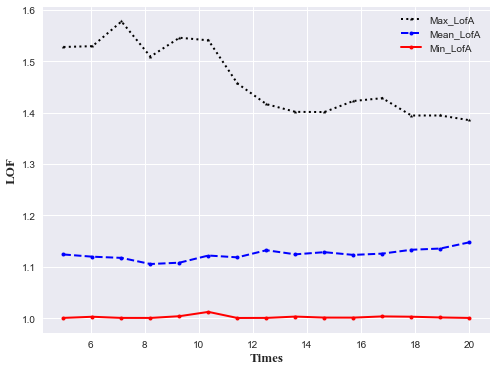

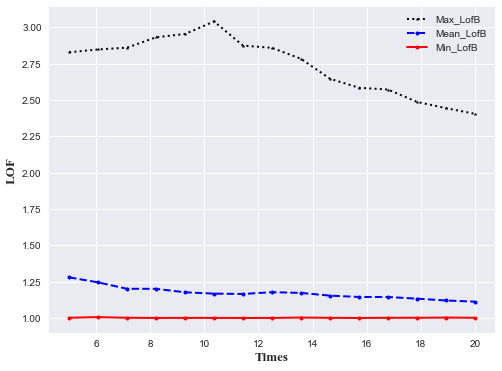

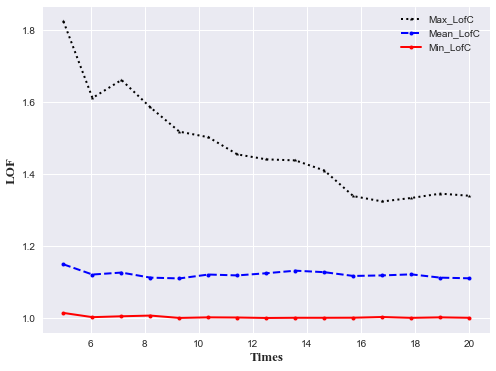

In [6]:

font = {'family':'Times new roman', 'weight':'normal', 'size': 13}  
plt.figure(figsize=(8, 6), facecolor='w')
ax = plt.subplot(1, 1, 1)
x_plot = np.linspace(5, 5+Count, Count)
ax.plot(x_plot, Max_lof_A, 'k*:', markersize=4, linewidth=2, label='Max_LofA')
ax.plot(x_plot, Mean_lof_A, 'bo--', markersize=4, linewidth=2, label='Mean_LofA')
ax.plot(x_plot, Min_lof_A, 'ro-', markersize=4, linewidth=2, label='Min_LofA')
plt.legend()
plt.xlabel("Times", fontdict=font)
plt.ylabel("LOF", fontdict=font)
plt.show()


plt.figure(figsize=(8, 6), facecolor='w')
ax = plt.subplot(1, 1, 1)
x_plot = np.linspace(5, 5+Count, Count)
ax.plot(x_plot, Max_lof_B, 'k*:', markersize=4, linewidth=2, label='Max_LofB')
ax.plot(x_plot, Mean_lof_B, 'bo--', markersize=4, linewidth=2, label='Mean_LofB')
ax.plot(x_plot, Min_lof_B, 'ro-', markersize=4, linewidth=2, label='Min_LofB')
plt.legend()
plt.xlabel("Times", fontdict=font)
plt.ylabel("LOF", fontdict=font)
plt.show()


plt.figure(figsize=(8, 6), facecolor='w')
ax = plt.subplot(1, 1, 1)
x_plot = np.linspace(5, 5+Count, Count)
ax.plot(x_plot, Max_lof_C, 'k*:', markersize=4, linewidth=2, label='Max_LofC')
ax.plot(x_plot, Mean_lof_C, 'bo--', markersize=4, linewidth=2, label='Mean_LofC')
ax.plot(x_plot, Min_lof_C, 'ro-', markersize=4, linewidth=2, label='Min_LofC')
plt.legend()
plt.xlabel("Times", fontdict=font)
plt.ylabel("LOF", fontdict=font)
plt.show()

In [12]:
Max_lof_B
Mean_lof_B
Min_lof_B
# LOF_B = Max_lof_B
LOF_B = np.vstack((Max_lof_B, Mean_lof_B, Min_lof_B ))
print(LOF_B)
# np.savetxt('E:/Code/Bayescode/QW_reliable/LOFG_BN/Picture/LOF_B.csv', LOF_B, delimiter = ',')

[[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [7]:
# 对于Instane2二维数据,取9~12都可以
# 对Instane5五维数据
lof_A = outliers(9, Instane5_A)
lof_B = outliers(10, Instane5_B)
lof_C = outliers(7, Instane5_C)
# for outlier in lof:
# #     if outlier["lof"]>1.5:
#     print(outlier["lof"], outlier["instance"], outlier["index"])

In [13]:
# 建立序列与故障对应的权重值，用于权重LOF，与权重贝叶斯
# GrubbsList: 临界值，第一行为n=7,第二行为n=11，第一个数为0.95.第二个为0.99时的阈值
# Lof_Score为得分
import copy
GrubbsList = [[1.828, 1.938, 2.097], [2.088, 2.176, 2.410]] 
LinJieZhi = 0 #0代表0.90；1代表取0.95;1代表取0.99
# ================================================================
# Mean_Lof:求解每3组的LOF均值，用于判断是否为噪声点的条件
# Lof_Score：LOF得分原始输入，默认全部为1,返回对应的序列得分大小
# Instane5：输入为Instane5_A/B/C,用于计算大小
# lof为已经计算好的各省lof框架
# Fault：为输入原始数据，已经按照12行排列好
# LinJieZhi为临界值，控制Grubbs的阈值
# ================================================================
def Mean_Lof(Instane5, lof, Fault, LinJieZhi=0):
    Lof_Score = [1 for i in range(len(Instane5))]
    if len(Instane5)==132:
        MeanLof_Len = 11 #这里11需要根据省修改：取11或是7
        JJ = 1
    else:
        MeanLof_Len = 7
        JJ = 0
    #   序列得分赋值
    for outlier in lof:
        Lof_Score[outlier['index']] = outlier['lof']
    Lof_ScoreSort = [Lof_Score[i*12:(i+1)*12] for i in np.arange(MeanLof_Len)] 
    
    #     每三组得分均值计算与权重赋值
    Weight_matrix = copy.deepcopy(Lof_ScoreSort)
    Weight_matrix = np.array(Weight_matrix)
    Weight_matrix_T = Weight_matrix.T
    Mean_Lof = [0,0,0,0]
    Lof_ScoreSort = np.array(Lof_ScoreSort)
    Lof_ScoreSort_T = Lof_ScoreSort.T #转置一下，便于与均值作比较
    for i in range(4):
        Mean_Lof[i] = Lof_ScoreSort[:, (i*3):(3*(i+1))].sum()
        Mean_Lof[i] = Mean_Lof[i]/(3*MeanLof_Len)     #计算均值

        for j in range(3):
            A = Lof_ScoreSort_T[(i*3+j), :]   #定位到行
#             以下代码为确定Grubbs值
            Every_line = Fault.T[(i*3+j)]
#             print(Every_line*100)
            Mean_line = Every_line.mean() #计算均值
            Std_line = Every_line.std()   #计算标准差
#             以上代码为确定Grubbs值            
            for IP in range(MeanLof_Len):
                B = A[IP]                     #定位到列中具体数
                if B < Mean_Lof[i]:
                    Weight_matrix_T[(i*3+j), IP] = 1  #权值赋值
                else:
                    Z_Score = abs(Every_line[IP] - Mean_line)/Std_line
#                     print(Z_Score)
                    if Z_Score > GrubbsList[JJ][LinJieZhi]:
                        Weight_matrix_T[(i*3+j), IP] = np.exp(-B/4)   #权值赋值,这条语句还需要修改
                    else:
                        Weight_matrix_T[(i*3+j), IP] = 1  #权值赋值
                
    Weight_matrix = Weight_matrix_T.T
    
    return Mean_Lof, Lof_Score, Weight_matrix

Mean_Lof_A, Lof_Score_A, Weight_matrix_A = Mean_Lof(Instane5_A, lof_A, elec_faults_A, LinJieZhi)
Mean_Lof_B, Lof_Score_B, Weight_matrix_B = Mean_Lof(Instane5_B, lof_B, elec_faults2, LinJieZhi)
Mean_Lof_C, Lof_Score_C, Weight_matrix_C = Mean_Lof(Instane5_C, lof_C, elec_faults_C, LinJieZhi)

print(Mean_Lof_B)
# print(Lof_Score_B)
print(Weight_matrix_B)
# for i in Weight_matrix_B:
#     for j in i:
#         print(j)
# print(Weight_matrix_A)
# print(Weight_matrix_B)
# print(Weight_matrix_C)

[1.0528510681310639, 1.0522931064318972, 1.1279942652122346, 1.1530469839491675]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [14]:
Weight_All = []
Weight_matrix_A = np.array(Weight_matrix_A)
Weight_matrix_B = np.array(Weight_matrix_B)
Weight_matrix_C = np.array(Weight_matrix_C)

a = Weight_matrix_A.flatten()
b = Weight_matrix_B.flatten()
c = Weight_matrix_C.flatten()
a_list=list(a)
b_list=list(b)
c_list=list(c)
a_list.extend(b_list)
a_list.extend(c_list)
print(len(a_list))

Weight_All = a_list
Weight_Fault_ABC_All = Weight_All*elec_faultsA
print(Weight_All)
print(elec_faultsA*100)
print(Weight_Fault_ABC_All*100)

# np.savetxt('Weight_Fault_ABC_All.csv', Weight_Fault_ABC_All, delimiter = ',')

300
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7616722722981006, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7550696176433305, 0.7425122138478218, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7525875031238985, 1.0, 1.0, 1.0, 0.6931186365266048, 0.755993751628528, 1.0, 1.0, 0.7223949066384284, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

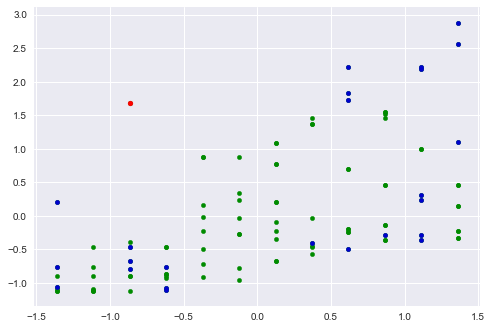

In [15]:
# lof = outliers(10, Instane5_A)

x, y = zip(*Instane2_C)
plt.scatter(y, x, s=20, color="#008B00")


for outlier in lof_C:
    value = outlier["lof"]
    instance = outlier["instance"]
    if value>1.1 and value<=1.5:
        color = "#0000CD" #蓝色
    elif value > 1.5:
        color = "#FF0000"  #红色
    else:
        color = "#008B00"  #绿色
    plt.scatter(instance[1], instance[0], color=color, s=(value-1)**2*10+20)
plt.show()

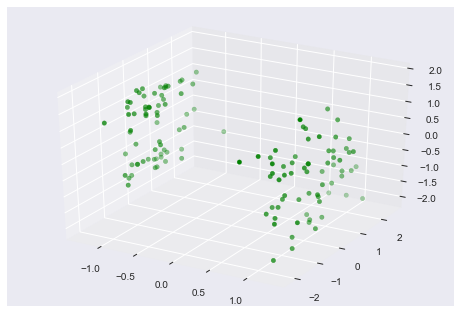

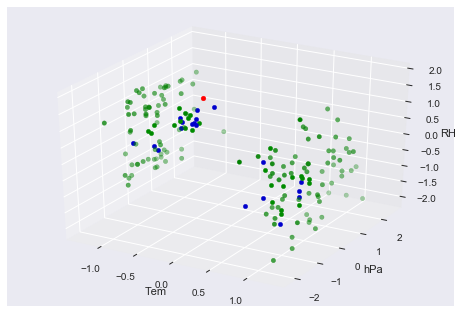

1.0038045374614777
[-0.49856398148942194, 0.12385123055743918, -0.8068704567806038, -0.9028480271086362, 0.8282065019349321]


In [17]:
ax = plt.subplot(111, projection='3d')
ax.scatter(elec_RH1, elec_hPa1, elec_tem1, c='g')
plt.show()

ax = plt.subplot(111, projection='3d')
ax.scatter(elec_RH1, elec_hPa1, elec_tem1, c='g')
for outlier in lof_A:
    value = outlier["lof"]
    instance = outlier["instance"]
    
    if value>1.1 and value<=1.5:
        color = "#0000CD" #蓝色
    elif value > 1.5:
        color = "#FF0000"  #红色
    else:
        color = "#008B00"
    ax.scatter(instance[4], instance[3], instance[2],  c=color, s=(value-1)**2*10+20)
#     ax.scatter(instance[2], instance[1], instance[0],  c=color, s=(value-1)**2*10+20)
ax.set_zlabel('RH')  # 坐标轴
ax.set_ylabel('hPa')
ax.set_xlabel('Tem')
plt.show()
print(outlier["lof"])
print(outlier["instance"])

sklearn--Anomaly detection with Local Outlier Factor (LOF)
---

Grubbs异常点检测
---

In [10]:
print(elec_faults2*100)

# =====================================================================================
# GrubbsList: 临界值，第一行为n=7,第二行为n=11，第一个数为0.95.第二个为0.99时的阈值
# GrubbS：计算elec_faults2每列的Grubbs值
# 输入值：Fault：排列好的故障率数据，每个地点一组数据，每组长度为12。elec_faults2
# 返回值：
#     Index.append(Max_line[0])              #返回每一组哪个数据的索引值
#     ZSCORE.append(Z_Score)                 #返回具体得分
#     II.append(i)                           #返回第几组索引
#     Value.append(Every_line[Max_line[0]])  #返回异常值对应原始值
# =====================================================================================
GrubbsList = [[1.938, 2.097], [2.176, 2.410]] 
LinJieZhi = 0 #0代表0.95；1代表取0.99
def GrubbS(Fault, LinJieZhi=1):
    Index = []
    ZSCORE = []
    II = []
    Value = []
    for i in np.arange(len(Fault.T)):
        Every_line = Fault[:, i]
        Mean_line = Every_line.mean() #计算均值
        Std_line = Every_line.std()   #计算标准差

        Temp = abs(Every_line - Mean_line)
        Max_line = np.where(Temp==np.max(Temp)) #返回最大值的索引
        Max_line = Max_line[0]        #返回索引

        Z_Score = Temp[Max_line[0]]/Std_line
        if len(Every_line)==7:   #确定是哪个省的数据，用于选择GrubbsList的行号
            JJ = 0
        if len(Every_line)==11:
            JJ = 1
            
        if Z_Score > GrubbsList[JJ][LinJieZhi]: #默认取0.95
            Index.append(Max_line[0])              #返回每一组哪个数据的索引值
            ZSCORE.append(Z_Score)                 #返回具体得分
            II.append(i)                           #返回第几组索引
            Value.append(Every_line[Max_line[0]])  #返回异常值对应原始值
    return Index, ZSCORE, II, Value

Max_index, Z_score, Hang_index, Max_Value = GrubbS(elec_faults2)
print(Max_index)
print(Hang_index)
print(Z_score)
print(Max_Value)

[[ 0.  0.  4.  3.  3.  3.  6.  5.  8.  6. 10.  6.]
 [ 0.  0.  1.  1.  3.  2.  3.  3.  2.  2.  8.  6.]
 [ 0.  0.  2.  1.  6.  6.  2.  2.  3.  2. 14. 13.]
 [ 1.  1.  5.  4. 30. 26. 23. 19. 25. 22. 22. 18.]
 [ 1.  1.  2.  2.  5.  4.  6.  5.  5.  5. 19. 15.]
 [ 2.  3.  3.  2. 52. 43.  9.  6. 49. 46. 43. 31.]
 [ 0.  0.  0.  0.  1.  0.  8.  6.  4.  3.  5.  4.]
 [ 0.  0.  1.  0.  3.  2. 19. 14. 13. 13. 15. 19.]
 [ 1.  0.  3.  3. 12. 17. 39. 31. 15. 13.  9. 12.]
 [ 0.  0.  3.  3. 11.  9. 33. 23. 13. 10. 96. 69.]
 [ 0.  0.  1.  0.  2.  2. 24. 23. 14. 16. 10.  8.]]
[5, 5, 5, 5, 5, 5, 9, 9]
[0, 1, 4, 5, 8, 9, 10, 11]
[2.544994774935888, 3.025846415214352, 2.6926810640520915, 2.5484898846797073, 2.7297074141559166, 2.7461046979694137, 2.9076660547459365, 2.8809798445643353]
[0.015306903413439462, 0.030613806826878923, 0.5204347160569417, 0.42859329557630493, 0.4898209092300628, 0.45920710240318385, 0.9598244892362539, 0.6855889208830386]
